# Deep Learning Course

## Assignment 2

### Assignment Goals

* Design and implementation of CNNs.
* CNN visualization.
* Implementation of ResNet.

In this assignment, you will be asked to learn CNN models for an image dataset. Different experiments will help you achieve a better understanding of CNNs.

### Dataset

The dataset consists of around 9K images (some grayscale and some RGB) belonging to 101 classes. The shape of each image is (64,64,3). Every image is labeled with one of the classes. The image file is contained in the folder named after the class name.


### Requirements

1. **(40 points) Implement and improve a CNN model.**

   (a) We are aiming to learn a CNN on the given dataset. Download the dataset, and use PyTorch to implement LeNet5 to classify instances. Use a one-hot encoding for labels. Split the dataset into training (90 percent) and validation (10 percent) and report the model loss (cross-entropy) and accuracy on both training and validation sets. (20 points)
   
    The LeNet5 configuration is:
      - Convolutional layer (kernel size 5 x 5, 32 filters, stride 1 x 1 and followed by ReLU)
      - Max Pooling layer with size 4 and stride 4 x 4
      - Convolutional layer (kernel size 5 x 5, 64 filters, stride 1 x 1 and followed by ReLU)
      - Max Pooling layer with size 4 and stride 4 x 4
      - Fully Connected ReLU layer that has 1021 neurons
      - Fully Connected ReLU layer with 84 neurons
      - Fully Connected Softmax layer that has input 84 and output which is equal to the number of classes (one node for each of the classes).

   (b) Try to improve model accuracy on the validation dataset by tuning the model hyperparameters. You can use any improvement methods you prefer. You are expected to reach at least 65 percent accuracy on validation set. (20 points)
    
    Here are some improvement methods you can use, of course you can use others which are not mentioned here:
    - Dropout
    - L1, L2 regularization
    - Try improved initialization (e.g., Xavier initialier)
    - Batch Normalization
    
   The grading of part (b) is based on the correctness of your implementation (5 points) and the performance of your improvement on the validation set. The validation accuracy and corresponding score is:
    - 65% (5 points)
    - 67% (8 points)
    - 69% (12 points)
    - 71% (15 points)


   **Structure of LENET-5**
   
   This following LENET-5 structure is for 10-class dataset. Therefore, the layer size is not exactly the same as ours.
   
   ![hw2_lenet5.png](hw2_lenet5.png)

2. **(20 points) Visualize layer activation**

    There are several approaches to understand and visualize convolutional Networks, including visualizing the activations and layers weights. The most straight-forward visualization technique is to show the activations of the network during the forward pass. The second most common strategy is to visualize the weights. For more information we recommend the course notes on ["Visualizing what ConvNets learn"](http://cs231n.github.io/understanding-cnn/). More advanced techniques can be found in "Visualizing and Understanding Convolutional Networks" paper by Matthew D.Zeiler and Rob Fergus.
    
    Please visualize the layer activation of **the first conv layer** and **the second conv layer** of your above CNN model (after completing Q1), on the following 2 images:
    - accordion/image_0001
    - camera/image_0001
    
   Visualizing a CNN layer activation means to visualize the result of the activation layer as an image. Specifically, the activation of the first conv layer is the output of the first (conv + ReLU) layer during forward propagation. Since we have 32 filters in the first conv layer, you should draw 32 activation images for the first conv layer. Please display multiple images side by side in a row to make your output more readable (Hint: matplotlib.pyplot.subplot).
    
    

3. **(40 points) ResNet Implementation**

    Use PyTorch to implement ResNet 18 to classify the given dataset. Same as above, please use a one-hot encoding for labels, split the dataset into training (90 percent) and validation (10 percent) and report the model loss (cross-entropy) and accuracy on both training and validation sets. See the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) for detailed introduction of ResNet.
    
    The grading of this part is mainly based on the implementation and performance on validation set. If you need more resources to complete the training, consider using Google Colab.
    
    The ResNet 18 configuration is:
    -  conv_1 (kernel size 7 x 7, 64 filters, stride 2 x 2)
    -  conv_2 (max pooling layer with size 3 x 3, followed by 2 blocks.Each block contains two conv layers. Each conv layer has kernel size 3 x 3, 64 filters, stride 2 x 2)
    -  conv_3 (2 blocks, each contains 2 conv layers with kernel size 3*3, 128 filters)
    -  conv_4 (2 blocks, each contains 2 conv layers with kernel size 3*3, 256 filters)
    -  conv_5 (2 blocks, each contains 2 conv layers with kernel size 3*3, 512 filters)
    
   A block has the structure:
   
    ![hw2_resnet.png](hw2_resnet.png)
    <!--<img src="attachment:image.png" alt="drawing" width="400"/>-->

### Submission Notes

Please use Jupyter Notebook. The notebook should include the final code, results and your answers. You should submit your Notebook in (.pdf or .html) and .ipynb format. (penalty 10 points)

## Your Implementation

In [1]:
# You can use the following helper functions

from typing import Any
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision.io import read_image
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:

class ImageDataset( Dataset ):

    def __init__(self, is_val= False, transform = None) -> None:


        if is_val:
            self.df = pd.read_csv( 'validation.csv', index_col=0 )
        else:
            self.df = pd.read_csv( 'train.csv', index_col= 0 )

        self.cls_names = self.df['cls_name'].unique().tolist()
        self.df['label'] = self.df['cls_name'].apply( self.cls_names.index )

        self.transform = transform


    def get_num_classes(self):
        return len( self.cls_names )

    def __len__(self):
        return len( self.df )

    def __getitem__(self, index):
        path = self.df.iloc[index]['path']
        img = read_image( path ).type( torch.float32 )

        target = self.df.iloc[index]['label']

        if self.transform is not None:
            img = self.transform( img )

        target = torch.tensor( target )
        one_hot_target=torch.zeros(101,dtype=torch.float32)
        one_hot_target[target]=1.0

        return img/255 , one_hot_target

def collate_fn( batch ):
    imgs, targets = [], []

    for img, target in batch:
        imgs.append( img )
        targets.append( target )

    imgs = torch.stack( imgs, dim= 0 )
    targets = torch.stack( targets, dim= 0 )
    return imgs, targets


In [4]:

num_epochs = 50
batch_size = 64
learning_rate = 0.0001
weight_decay = 0.00001
number_of_class=101


In [5]:
transform = transforms.Compose([
    #transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ),
    transforms.RandomVerticalFlip( .5 )
])

train_dataset = ImageDataset( is_val = False, transform = transform )
val_dataset = ImageDataset( is_val = True )

train_dataloader = DataLoader( train_dataset, batch_size = batch_size, shuffle= True, collate_fn=collate_fn )
val_dataloader = DataLoader( val_dataset, batch_size = batch_size, shuffle= True, collate_fn=collate_fn )


In [6]:

def init_weights( m ):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


###  Implement and improve a CNN model

In [7]:
def accuracy(model,dataloader,device):
  correct=0
  total=0
  with torch.no_grad():
    for inputs,labels in dataloader:
      inputs,labels= inputs.to(device), labels.to(device)
      outputs=model(inputs)
      _, pred=torch.max(outputs.data, 1)
      _, labels_indices=torch.max(labels,1)
      total+=labels.size(0)
      correct+=(pred==labels_indices).sum().item()

  accuracy=correct/total*100
  return accuracy

In [8]:
# implement your Lenet5 here

class CNN_LeNet5(nn.Module):
  def __init__(self):
    super(CNN_LeNet5,self).__init__()
    self.conv1=nn.Conv2d(3,32,kernel_size=5, stride=1)
    self.pool1=nn.MaxPool2d(kernel_size=4, stride=4)
    self.conv2=nn.Conv2d(32,64,kernel_size=5,stride=1)
    self.pool2=nn.MaxPool2d(kernel_size=4, stride=4)
    self.linear=nn.Sequential(
      nn.Flatten(),
      nn.Linear(2*2*64, 1021),
      nn.ReLU(),

      nn.Linear(1021,84),
      nn.ReLU(),
      nn.Linear(84,number_of_class),
      nn.Softmax(dim=1)
    )
    self.ReLU=nn.ReLU()
  def forward(self,x):
    x=self.ReLU(self.conv1(x))
    x=self.pool1(x)
    x=self.ReLU(self.conv2(x))
    x=self.pool2(x)
    x=self.linear(x)
    return x

model=CNN_LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    train_accuracy = accuracy(model,train_dataloader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], trainLoss: {epoch_loss:.4f},trainAccuracy: {train_accuracy:.4f}%")

    model.eval()
    running_loss = 0.0
    total_samples = 0
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    val_accuracy = accuracy(model,val_dataloader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], ValidationLoss: {epoch_loss:.4f},ValidationAccuracy: {val_accuracy:.4f}%")



Epoch [1/50], trainLoss: 4.5644,trainAccuracy: 9.2454%
Epoch [1/50], ValidationLoss: 4.5442,ValidationAccuracy: 8.7816%
Epoch [2/50], trainLoss: 4.5395,trainAccuracy: 9.2454%
Epoch [2/50], ValidationLoss: 4.5437,ValidationAccuracy: 8.7816%
Epoch [3/50], trainLoss: 4.5320,trainAccuracy: 11.3443%
Epoch [3/50], ValidationLoss: 4.5222,ValidationAccuracy: 10.8672%
Epoch [4/50], trainLoss: 4.5041,trainAccuracy: 13.3402%
Epoch [4/50], ValidationLoss: 4.5042,ValidationAccuracy: 12.9528%
Epoch [5/50], trainLoss: 4.4982,trainAccuracy: 13.5205%
Epoch [5/50], ValidationLoss: 4.5015,ValidationAccuracy: 12.9528%
Epoch [6/50], trainLoss: 4.4948,trainAccuracy: 15.8769%
Epoch [6/50], ValidationLoss: 4.4821,ValidationAccuracy: 15.6970%
Epoch [7/50], trainLoss: 4.4591,trainAccuracy: 19.3793%
Epoch [7/50], ValidationLoss: 4.4515,ValidationAccuracy: 18.4413%
Epoch [8/50], trainLoss: 4.4355,trainAccuracy: 20.2807%
Epoch [8/50], ValidationLoss: 4.4385,ValidationAccuracy: 19.7585%
Epoch [9/50], trainLoss: 4.4

In [9]:
num_epochs = 35
batch_size = 64
learning_rate = 0.001
weight_decay = 0.00001
number_of_class=101
# implement the improved of LeNet5:
class improve_of(nn.Module):
  def __init__(self):
    super(improve_of,self).__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2)
    )
    self.layer2=nn.Sequential(
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size=4)
    )
    self.layer3=nn.Sequential(
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4)
    )

    self.layer4=nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4)

    )

    self.layer5=nn.Sequential(
        nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    # )
#     self.layer7=nn.Sequential(
#         nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
#         nn.BatchNorm2d(128),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2)

#     )
#     self.layer8=nn.Sequential(
#         nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2)

#     )
    self.linear=nn.Sequential(
      nn.Flatten(),
      nn.Linear(2*2*128, 128),
      nn.ReLU(),

      # nn.Linear(256,512),
      # nn.ReLU(),

      # nn.Linear(512,256),
      # nn.ReLU(),

      # nn.Linear(256,128),
      # nn.ReLU(),

      nn.Linear(128,number_of_class)
    )
  def forward(self,x):
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)
    x=self.layer5(x)
    # x=self.layer6(x)
    # x=self.layer7(x)
    # x=self.layer8(x)
    x=self.linear(x)
    return x

model=improve_of().to(device)
model.apply(init_weights)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    train_accuracy = accuracy(model,train_dataloader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], trainLoss: {epoch_loss:.4f},trainAccuracy: {train_accuracy:.4f}%")

    model.eval()
    running_loss = 0.0
    total_samples = 0
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    val_accuracy = accuracy(model,val_dataloader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], ValidationLoss: {epoch_loss:.4f},ValidationAccuracy: {val_accuracy:.4f}%")


Epoch [1/35], trainLoss: 3.3303,trainAccuracy: 41.3598%
Epoch [1/35], ValidationLoss: 2.9887,ValidationAccuracy: 36.9923%
Epoch [2/35], trainLoss: 2.4479,trainAccuracy: 52.4723%
Epoch [2/35], ValidationLoss: 2.2976,ValidationAccuracy: 47.3106%
Epoch [3/35], trainLoss: 1.8892,trainAccuracy: 60.2369%
Epoch [3/35], ValidationLoss: 1.9906,ValidationAccuracy: 52.2503%
Epoch [4/35], trainLoss: 1.5199,trainAccuracy: 67.4994%
Epoch [4/35], ValidationLoss: 1.7810,ValidationAccuracy: 57.5192%
Epoch [5/35], trainLoss: 1.2597,trainAccuracy: 73.1908%
Epoch [5/35], ValidationLoss: 1.5417,ValidationAccuracy: 61.8002%
Epoch [6/35], trainLoss: 1.0815,trainAccuracy: 76.9379%
Epoch [6/35], ValidationLoss: 1.5147,ValidationAccuracy: 62.5686%
Epoch [7/35], trainLoss: 0.9143,trainAccuracy: 80.6979%
Epoch [7/35], ValidationLoss: 1.4667,ValidationAccuracy: 64.9835%
Epoch [8/35], trainLoss: 0.7742,trainAccuracy: 84.3291%
Epoch [8/35], ValidationLoss: 1.3574,ValidationAccuracy: 65.8617%
Epoch [9/35], trainLoss:

### Visualize layer activation

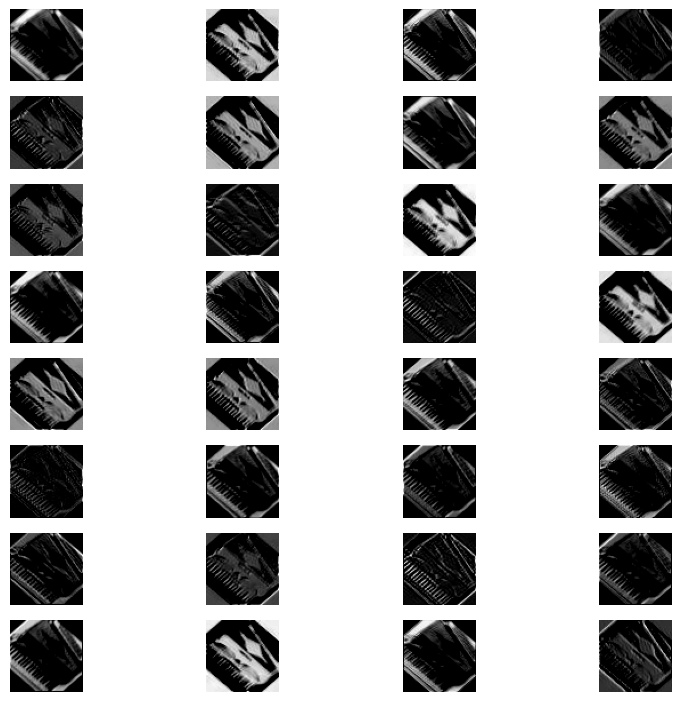

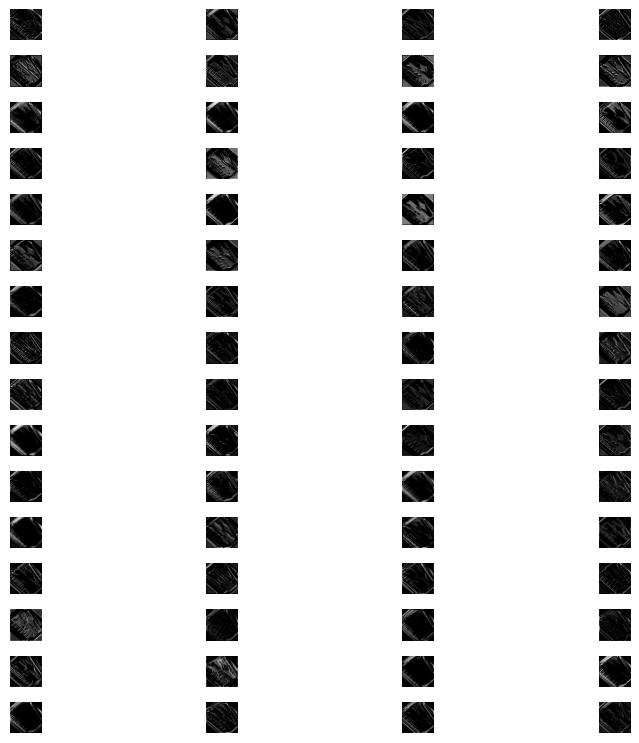

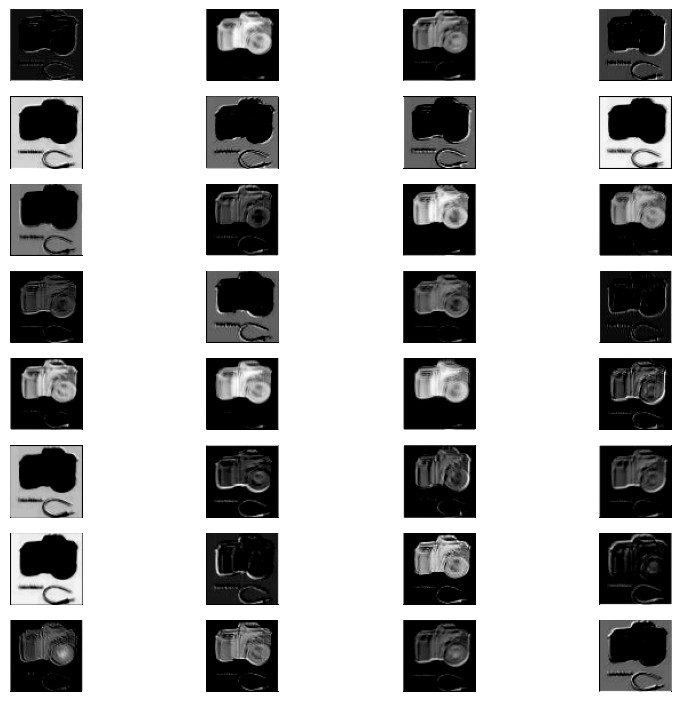

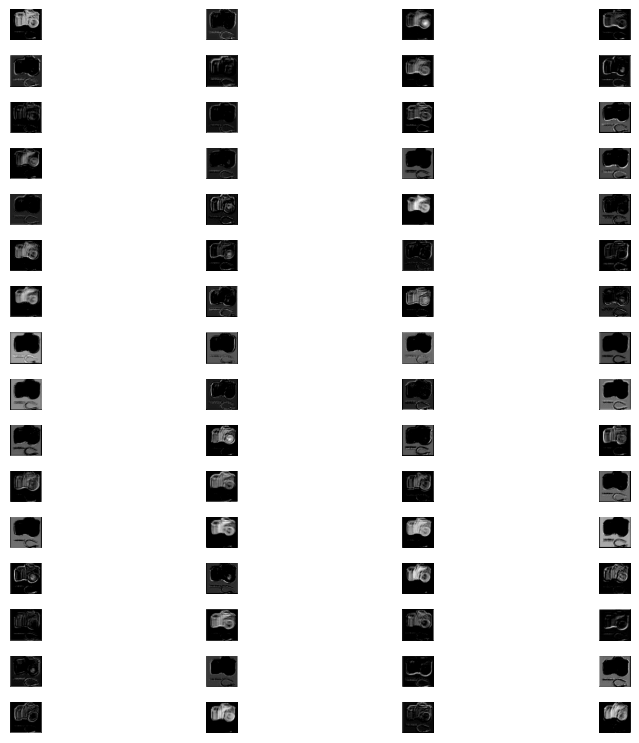

In [11]:
# implement your visualization here
def get_activation(model,input_image):
  activation=[]
  def hook(model,input,output):
    activation.append(output)
  hook_handle1 = model.layer1.register_forward_hook(hook)
  hook_handle2 = model.layer2.register_forward_hook(hook)
  model(input_image)
  for act in activation:
    num_channels = act.size(1)
    num_rows = num_channels//4+1
    plt.figure(figsize=(8,8))
    for j in range(num_channels):
        plt.subplot(num_rows, 4, j + 1)
        plt.imshow(act[0, j].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show
  hook_handle1.remove()
  hook_handle2.remove()

image_p1='accordion/image_0001.jpg'
image_p2='camera/image_0001.jpg'
image1=Image.open(f'Dataset/train/{image_p1}')
image2=Image.open(f'Dataset/train/{image_p2}')
x1=TF.to_tensor(image1)
x1.unsqueeze_(0)
x2=TF.to_tensor(image2)
x2.unsqueeze_(0)
get_activation(improve_of().cpu(),x1)
get_activation(improve_of().cpu(),x2)






In [12]:

num_epochs = 30
batch_size = 32
learning_rate = 0.001

weight_decay = 0.00001
number_of_class=101

# transform = transforms.Compose([
#     transforms.Resize(224),
# ])
# val_transform = transforms.Compose([
#     transforms.Resize(224),
# ])
t_d = ImageDataset( is_val = False)
v_d = ImageDataset( is_val = True)

train_loader = DataLoader( t_d, batch_size = batch_size, shuffle= True, collate_fn=collate_fn )
val_loader = DataLoader( v_d, batch_size = batch_size, shuffle= True, collate_fn=collate_fn )


### ResNet Implementation

In [ ]:

# implement a ResNet model here
class ResidualBlock(nn.Module):
    def __init__(self, input, output, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input,output,kernel_size=3,stride=stride,padding=1),
            nn.BatchNorm2d(output),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(output,output,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(output)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self,x):
        residual = x
        result =self.conv1(x)
        result =self.conv2(result)
        if self.downsample is not None:
            residual=self.downsample(x)
        result+=residual
        result=self.relu(result)
        return result

class ResNet(nn.Module):
  def __init__(self, block, layers, number_of_class=101):
    super(ResNet, self).__init__()
    self.in_channels=64
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    self.Maxpool = nn.MaxPool2d(kernel_size=3)
    self.layer1 = self._make_layer(block, 64, layers[0],stride=2)
    self.layer2 = self._make_layer(block, 128, layers[1])
    self.layer3 = self._make_layer(block, 256, layers[2])
    self.layer4 = self._make_layer(block, 512, layers[3])
    self.avgpool = nn.AvgPool2d(3, stride=1)
    self.fc = nn.Linear(4608, number_of_class)

  def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride!=1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
  def forward(self, x):
    x = self.conv1(x)
    x = self.Maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x
model = ResNet(ResidualBlock, [2, 2, 2, 2], number_of_class).to(device)
model.apply(init_weights)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    train_accuracy = accuracy(model,train_loader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], trainLoss: {epoch_loss:.4f},trainAccuracy: {train_accuracy:.4f}%")

    model.eval()
    running_loss = 0.0
    total_samples = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss+= loss.item() * inputs.size(0)
        total_samples+= inputs.size(0)

    epoch_loss = running_loss/total_samples
    val_accuracy = accuracy(model,val_loader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], ValidationLoss: {epoch_loss:.4f},ValidationAccuracy: {val_accuracy:.4f}%")




Epoch [1/30], trainLoss: 3.9189,trainAccuracy: 36.1834%
Epoch [1/30], ValidationLoss: 3.0943,ValidationAccuracy: 34.0285%
Epoch [2/30], trainLoss: 2.7107,trainAccuracy: 48.2745%
Epoch [2/30], ValidationLoss: 2.4403,ValidationAccuracy: 44.2371%
Epoch [3/30], trainLoss: 2.1464,trainAccuracy: 56.1937%
Epoch [3/30], ValidationLoss: 2.2412,ValidationAccuracy: 47.6400%
Epoch [4/30], trainLoss: 1.7414,trainAccuracy: 64.4605%
Epoch [4/30], ValidationLoss: 1.9035,ValidationAccuracy: 53.2382%
Epoch [5/30], trainLoss: 1.4424,trainAccuracy: 70.8859%
Epoch [5/30], ValidationLoss: 1.7627,ValidationAccuracy: 58.2876%
Epoch [6/30], trainLoss: 1.1568,trainAccuracy: 76.4229%
Epoch [6/30], ValidationLoss: 1.7019,ValidationAccuracy: 59.4951%
Epoch [7/30], trainLoss: 0.9332,trainAccuracy: 82.4363%
Epoch [7/30], ValidationLoss: 1.6855,ValidationAccuracy: 61.2514%
Epoch [8/30], trainLoss: 0.7451,trainAccuracy: 85.7971%
Epoch [8/30], ValidationLoss: 1.6472,ValidationAccuracy: 60.8123%
Epoch [9/30], trainLoss: